<a href="https://colab.research.google.com/github/parvvaresh/Classification-Persian-News/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install and import libs

In [ ]:
from google.colab import output
!pip install hazm
!pip install mapply


import warnings
import hazm
from hazm import *
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import mapply
import glob
from wordcloud import WordCloud
from hazm import stopwords_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import os


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    cohen_kappa_score,
    make_scorer
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn import ensemble, linear_model, naive_bayes, neighbors, tree
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')


output.clear()

# Initialization

1. **Parallel Processing Setup:**  
   - `mapply.init(...)` initializes a parallel processing framework with multiple workers (`n_workers=-1` uses all available processors), processing data in chunks (`chunk_size=100` and `max_chunks_per_worker=8`), with a visible progress bar.

2. **Text Cleaning Components:**  
   - **Punctuations:**  
     - Combines English (`string.punctuation`) and Persian punctuation symbols (`persian_punctuations`) into a single list for later removal.
   - **Diacritics:**  
     - Compiles a regex (`arabic_diacritics`) to remove common Arabic diacritics (e.g., Tashdid, Fatha, etc.).
   - **Lemmatization and Normalization:**  
     - Initializes `hazm.Lemmatizer()` for lemmatizing Persian words.  
     - Initializes a `Normalizer()` to standardize text.


3. **Stopwords Loading:**  
   - Uses `glob` to find all text files with Persian stopwords in a specific folder.
   - Reads each file and compiles a master list of stopwords.
   - Removes newline characters from each stopword.
   - Extends the list with additional stopwords from `stopwords_list()` from hazm.



This setup prepares your environment to clean, normalize, and process Persian text data efficiently in a parallelized manner.

In [ ]:
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=True,
)

persian_punctuations = '''`÷×؛#<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
punctuations_list = string.punctuation + persian_punctuations
arabic_diacritics = re.compile("""
                          ّ    | # Tashdid
                          َ    | # Fatha
                          ً    | # Tanwin Fath
                          ُ    | # Damma
                          ٌ    | # Tanwin Damm
                          ِ    | # Kasra
                          ٍ    | # Tanwin Kasr
                          ْ    | # Sukun
                          ـ     # Tatwil/Kashida
                      """, re.VERBOSE)
lemmatizer = hazm.Lemmatizer()
normalizer = Normalizer()


file_list = glob.glob('/content/drive/MyDrive/NLP/persian_stopwords' + '/*.txt')

stop_words = []

for file_path in file_list:
    with open(file_path) as f:
        stop_words.extend(f.readlines())

for i in range(len(stop_words)):
    stop_words[i]=stop_words[i].replace('\n','')

stop_words.extend(stopwords_list())
output.clear()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/get news/farsnews/farsnews_fainal.csv")

df = df.drop(['Unnamed: 0', 'date'], axis=1)
df = df.dropna()
df.head(5)

,title,text,label
0,قارایی: در تلاشم تا سیاه نمایی درباره ایران با...,خبرگزاری فارس - گروه هنر و رسانه - علی عبدالهی...,culture-media
1,توجه ویژه به اقوام و چهره های مردمی در فصل جدی...,به گزارش خبرگزاری فارس، پویان هدایتی، تهیه کن...,culture-media
2,جان فدا| ویژه برنامه هاى تلویزیون در سومین سال...,به گزارش خبرنگار رادیو و تلویزیون خبرگزاری فار...,culture-media
3,محمد علی صائب رئیس خبرگزاری صدا وسیما شد,به گزارش خبرگزاری فارس، علیرضا خدابخشی، معاون ...,culture-media
4,«همراه با خاطره ها» تمدید شد,به گزارش خبرگزاری فارس به نقل از روابط عمومی و...,culture-media


In [ ]:
label_counts = df["label"].value_counts().reset_index()
label_counts.columns = ["label", "count"]
label_counts

,label,count
0,sports,21396
1,social,12801
2,culture-media,11324
3,economy,10163
4,politics,9258


In [ ]:
class preprocessing:
  def __init__(self):
    pass

  def _remove_diacritics(self, text):
    text = re.sub(arabic_diacritics, '', text)
    return text


  def _remove_crash_data(self, text):
    if isinstance(text, str):
      return text
    else:
      return None

  def _remove_punctuations(self, text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

  def _remove_repeating_char(self, text):
    return re.sub(r'(.)\1+', r'\1', text)


  def _normalize_persian(self, text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ي", "ی", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ی", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ك" ,"ک" , text)
    text = re.sub("[^ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی]", " ", text)
    text = re.sub("[^\S\n\t]+", ' ', text)
    text = normalizer.normalize(text)
    return text


  def _tokenize(self, text):
    return word_tokenize(text)

  def _remove_stopwords(self, words):
    return [word  for word in words if word not in stop_words and len(word) > 2]

  def _lemmatizer(self, words):
    result = list()
    for token in words:
      result.append(lemmatizer.lemmatize(token))
    return self._remove_stopwords(result)

In [ ]:

pp = preprocessing()
df['title - preproces'] = df['title'].mapply(pp._remove_diacritics)
df['title - preproces'] = df['title - preproces'].mapply(pp._remove_punctuations)
df['title - preproces'] = df['title - preproces'].mapply(pp._remove_repeating_char)
df['title - preproces'] = df['title - preproces'].mapply(pp._normalize_persian)
df['title - preproces'] = df['title - preproces'].mapply(pp._tokenize)
df['title - preproces'] = df['title - preproces'].mapply(pp._remove_stopwords)
df['title - preproces'] = df['title - preproces'].mapply(pp._lemmatizer)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# Ensure that the preprocessed column contains strings rather than lists of tokens.
# If your column "title - preproces" contains token lists, join them into a single string.
df['preprocessed_text'] = df['title - preproces'].apply(lambda tokens: " ".join(tokens) if isinstance(tokens, list) else tokens)

# Create a TF-IDF vectorizer with a maximum of 100 features.
vectorizer = TfidfVectorizer(max_features=100)

# Fit the vectorizer and transform the preprocessed text into a TF-IDF weighted document-term matrix.
tfidf_matrix = vectorizer.fit_transform(df['preprocessed_text'])

# Optionally, you can extract the feature names and check the shape of the matrix.
feature_names = vectorizer.get_feature_names_out()
print("Feature names:", feature_names)
print("TF-IDF matrix shape:", tfidf_matrix.shape)


Feature names: ['اجرای' 'اروپا' 'ازاد' 'استقلال' 'اسلامی' 'اسیا' 'اعلام' 'اغاز' 'افزایش'
 'امام' 'امروز' 'امریکا' 'انقلاب' 'ایران' 'ایرانی' 'اینده' 'بازار' 'بازی'
 'بازیکن' 'باشگاه' 'بانک' 'برتر' 'برد' 'برنامه' 'برگزار' 'برگزاری' 'بورس'
 'تهران' 'تولید' 'تیم' 'جام' 'جزییات' 'جشنواره' 'جهان' 'جهانی' 'حضور'
 'خودرو' 'دار' 'داشت' 'درصد' 'درصدی' 'ده' 'دولت' 'دیدار' 'رس' 'رسید' 'روز'
 'روسیه' 'رونالدو' 'رییس' 'سازمان' 'سال' 'ستاره' 'سرمربی' 'شد' 'شرکت'
 'شهید' 'شو' 'شورای' 'شکست' 'طرح' 'عکس' 'فارس' 'فدراسیون' 'فرهنگ' 'فوتبال'
 'فیلم' 'قهرمان' 'قهرمانی' 'قیمت' 'لیگ' 'ماه' 'مجلس' 'مردم' 'مسابقات'
 'مسی' 'مقابل' 'ملی' 'میلیارد' 'میلیون' 'نفت' 'ها' 'هزار' 'هفته' 'هیات'
 'والیبال' 'واکنش' 'وزارت' 'وزیر' 'وضعیت' 'پایان' 'پرسپولیس' 'کار' 'کاهش'
 'کتاب' 'کرد' 'کشتی' 'کشور' 'کن' 'گیر']
TF-IDF matrix shape: (64942, 100)


# Define your classification_parameter_finder function (as given)


Performs hyperparameter tuning for a classification model usingGridSearchCV,evaluates performance on training and testing sets, and returns a summary DataFrame.

Parameters:
- model: sklearn estimator The machine learning model (e.g., KNeighborsClassifier, SVC, etc.).
- parameters: dict Hyperparameter grid for GridSearchCV.
- X_train: np.array Training features.
- y_train: np.array Training labels.
- X_test: np.array Testing features.
- y_test: np.array Testing labels.
- method: str Name of the method or experiment.
- path: str Output directory path (reserved for saving outputs if needed).

Returns: results: pandas.DataFrame A DataFrame summarizing the best model parameters, performance metrics,runtime, and best estimator.

In [ ]:
warnings.filterwarnings("ignore")

def classification_parameter_finder(model,
                                    parameters: dict,
                                    X_train: np.array,
                                    y_train: np.array,
                                    X_test: np.array,
                                    y_test: np.array,
                                    method: str,
                                    path: str):
    """

    """
    model_name = str(model).split('(')[0]
    start = time.time()

    # Use Cohen's kappa as the scoring metric
    kappa_scorer = make_scorer(cohen_kappa_score)

    from sklearn.model_selection import GridSearchCV  # Import here if needed

    grid = GridSearchCV(model,
                        param_grid=parameters,
                        refit=True,
                        cv=5,
                        n_jobs=-1,
                        scoring=kappa_scorer)
    grid.fit(X_train, y_train)

    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_test_pred)

    end = time.time()

    # Store results in a DataFrame
    results = pd.DataFrame({
        "method": [method],
        "model": [model_name],
        "best_params": [grid.best_params_],
        "train_accuracy": [train_accuracy],
        "test_accuracy": [test_accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1_score": [f1],
        "kappa": [kappa],
        "runtime": [end - start],
        "best_model": [grid.best_estimator_]
    })

    return results

# List of models (MLA)

# Machine Learning Models and Hyperparameter Grids

This repository includes a collection of machine learning models along with their respective hyperparameter search grids.

## List of Models and Hyperparameter Grids

| Model Name                    | Hyperparameter          | Values                           |
|--------------------------------|-------------------------|----------------------------------|
| **AdaBoostClassifier**         | `n_estimators`         | [50, 100, 200]                  |
|                                | `learning_rate`        | [0.5, 1.0, 1.5]                 |
| **BaggingClassifier**          | `n_estimators`         | [10, 50, 100]                   |
|                                | `max_samples`          | [0.5, 1.0]                      |
|                                | `max_features`         | [0.5, 1.0]                      |
| **RandomForestClassifier**     | `n_estimators`         | [50, 100, 200]                  |
|                                | `max_depth`           | [None, 10, 20]                  |
|                                | `min_samples_split`    | [2, 5, 10]                      |
| **ExtraTreesClassifier**       | `n_estimators`         | [50, 100, 200]                  |
|                                | `max_depth`           | [None, 10, 20]                  |
|                                | `min_samples_split`    | [2, 5, 10]                      |
| **PassiveAggressiveClassifier**| `C`                   | [0.1, 1.0, 10.0]                |
|                                | `max_iter`            | [1000, 2000]                    |
| **SGDClassifier**              | `loss`                | ["hinge", "log"]                |
|                                | `penalty`             | ["l2", "l1", "elasticnet"]      |
|                                | `alpha`               | [0.0001, 0.001, 0.01]           |
|                                | `max_iter`            | [1000, 2000]                    |
| **Perceptron**                 | `penalty`             | [None, "l2", "l1", "elasticnet"] |
|                                | `alpha`               | [0.0001, 0.001, 0.01]           |
|                                | `max_iter`            | [1000, 2000]                    |
| **LogisticRegression**         | `C`                   | [0.01, 0.1, 1, 10]              |
|                                | `penalty`             | ["l2"]                          |
|                                | `solver`              | ["lbfgs"]                       |
| **BernoulliNB**                | `alpha`               | [0.1, 0.5, 1.0]                 |
|                                | `binarize`            | [0.0, 0.5, 1.0]                 |
| **MultinomialNB**              | `alpha`               | [0.1, 0.5, 1.0]                 |
| **KNeighborsClassifier**       | `n_neighbors`         | [3, 5, 7]                       |
|                                | `weights`             | ["uniform", "distance"]         |
|                                | `metric`              | ["euclidean", "manhattan"]      |
| **DecisionTreeClassifier**     | `criterion`           | ["gini", "entropy"]             |
|                                | `max_depth`           | [None, 10, 20]                  |
|                                | `min_samples_split`    | [2, 5, 10]                      |
| **ExtraTreeClassifier**        | `criterion`           | ["gini", "entropy"]             |
|                                | `max_depth`           | [None, 10, 20]                  |
|                                | `min_samples_split`    | [2, 5, 10]                      |
| **XGBClassifier**              | `n_estimators`        | [50, 100, 200]                  |
|                                | `max_depth`           | [3, 5, 7]                       |
|                                | `learning_rate`       | [0.01, 0.1, 0.2]                |

This table provides a clear overview of all machine learning models along with their hyperparameter search grids.


In [ ]:
# List of models (MLA)
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.ExtraTreesClassifier(),

    # Linear Models
    linear_model.PassiveAggressiveClassifier(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    linear_model.LogisticRegression(),

    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.MultinomialNB(),

    # Nearest Neighbor (KNN)
    neighbors.KNeighborsClassifier(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Gradient Boosting Tree
    XGBClassifier(eval_metric='mlogloss')
]

# Hyperparameter grids for each model (keys should match the model class name)
hyperparameter_grids = {
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.5, 1.0, 1.5]
    },
    "BaggingClassifier": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 1.0],
        "max_features": [0.5, 1.0]
    },
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "ExtraTreesClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "PassiveAggressiveClassifier": {
        "C": [0.1, 1.0, 10.0],
        "max_iter": [1000, 2000]
    },
    "SGDClassifier": {
        "loss": ["hinge", "log"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": [0.0001, 0.001, 0.01],
        "max_iter": [1000, 2000]
    },
    "Perceptron": {
        "penalty": [None, "l2", "l1", "elasticnet"],
        "alpha": [0.0001, 0.001, 0.01],
        "max_iter": [1000, 2000]
    },
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "BernoulliNB": {
        "alpha": [0.1, 0.5, 1.0],
        "binarize": [0.0, 0.5, 1.0]
    },
    "MultinomialNB": {
        "alpha": [0.1, 0.5, 1.0]
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "ExtraTreeClassifier": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "XGBClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

## test and train solit

In [ ]:
X = tfidf_matrix
y = df["label"]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## encode labels

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Transform test labels using the same encoder

## train all models

In [13]:
results_list = []
output_path = "output"  # Directory for output files if needed
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Loop over each model in MLA, check if hyperparameter grid exists, and run grid search.
for model in MLA:
    model_name = str(model).split('(')[0]

    # Check if a hyperparameter grid is defined for this model.
    if model_name not in hyperparameter_grids:
        print(f"Skipping {model_name} as no hyperparameter grid is defined.")
        continue

    print(f"Starting hyperparameter tuning for {model_name}...")
    params = hyperparameter_grids[model_name]
    result = classification_parameter_finder(model, params, X_train, y_train_encoded, X_test, y_test_encoded, model_name, output_path)
    results_list.append(result)
    print(f"Finished tuning for {model_name}. Best parameters: {result['best_params'].values[0]}\n")

Starting hyperparameter tuning for AdaBoostClassifier...
Finished tuning for AdaBoostClassifier. Best parameters: {'learning_rate': 1.5, 'n_estimators': 200}

Starting hyperparameter tuning for BaggingClassifier...
Finished tuning for BaggingClassifier. Best parameters: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}

Starting hyperparameter tuning for RandomForestClassifier...
Finished tuning for RandomForestClassifier. Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

Starting hyperparameter tuning for ExtraTreesClassifier...
Finished tuning for ExtraTreesClassifier. Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

Starting hyperparameter tuning for PassiveAggressiveClassifier...
Finished tuning for PassiveAggressiveClassifier. Best parameters: {'C': 0.1, 'max_iter': 1000}

Starting hyperparameter tuning for SGDClassifier...
Finished tuning for SGDClassifier. Best parameters: {'alpha': 0.0001, 'loss': 

## Combine and display the results for all models


In [14]:
final_results = pd.concat(results_list, ignore_index=True)
final_results

,method,model,best_params,train_accuracy,test_accuracy,precision,recall,f1_score,kappa,runtime,best_model
0,AdaBoostClassifier,AdaBoostClassifier,"{'learning_rate': 1.5, 'n_estimators': 200}",0.587743,0.592116,0.724419,0.592116,0.598026,0.473169,135.418153,"(DecisionTreeClassifier(max_depth=1, random_st..."
1,BaggingClassifier,BaggingClassifier,"{'max_features': 1.0, 'max_samples': 0.5, 'n_e...",0.683445,0.634614,0.667825,0.634614,0.637644,0.529296,942.620744,(DecisionTreeClassifier(random_state=451123358...
2,RandomForestClassifier,RandomForestClassifier,"{'max_depth': None, 'min_samples_split': 10, '...",0.689912,0.634922,0.667169,0.634922,0.638295,0.530298,1011.212911,"(DecisionTreeClassifier(max_features='sqrt', m..."
3,ExtraTreesClassifier,ExtraTreesClassifier,"{'max_depth': None, 'min_samples_split': 10, '...",0.692876,0.635461,0.667117,0.635461,0.639063,0.530954,1092.842656,"(ExtraTreeClassifier(min_samples_split=10, ran..."
4,PassiveAggressiveClassifier,PassiveAggressiveClassifier,"{'C': 0.1, 'max_iter': 1000}",0.621081,0.624682,0.640799,0.624682,0.625739,0.516076,5.961219,PassiveAggressiveClassifier(C=0.1)
5,SGDClassifier,SGDClassifier,"{'alpha': 0.0001, 'loss': 'hinge', 'max_iter':...",0.588031,0.586265,0.586527,0.586265,0.553996,0.451771,17.570035,SGDClassifier(max_iter=2000)
6,Perceptron,Perceptron,"{'alpha': 0.0001, 'max_iter': 1000, 'penalty':...",0.563047,0.563708,0.646682,0.563708,0.556809,0.446402,15.370209,Perceptron(penalty='elasticnet')
7,LogisticRegression,LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.632264,0.636231,0.662885,0.636231,0.638814,0.531478,12.830528,LogisticRegression(C=1)
8,BernoulliNB,BernoulliNB,"{'alpha': 0.1, 'binarize': 0.0}",0.623795,0.626222,0.653635,0.626222,0.629150,0.517261,0.826272,BernoulliNB(alpha=0.1)
9,MultinomialNB,MultinomialNB,{'alpha': 0.5},0.594691,0.591808,0.588176,0.591808,0.567231,0.453628,0.382899,MultinomialNB(alpha=0.5)


## Create a copy of the results DataFrame to work with


In [15]:
results_df = final_results.copy()

# Normalize the metrics for composite calculation.
# Here, we assume that higher values indicate better performance.
metrics = ['test_accuracy', 'precision', 'recall', 'f1_score', 'kappa']
for metric in metrics:
    min_val = results_df[metric].min()
    max_val = results_df[metric].max()
    results_df[f"{metric}_norm"] = (results_df[metric] - min_val) / (max_val - min_val)

# Calculate a composite score as the average of the normalized metrics.
results_df['composite_metric'] = results_df[[f"{m}_norm" for m in metrics]].mean(axis=1)

# Display the updated results with the composite metric
results_df[['model', 'best_params', 'test_accuracy', 'precision', 'recall', 'f1_score', 'kappa', 'composite_metric']]

,model,best_params,test_accuracy,precision,recall,f1_score,kappa,composite_metric
0,AdaBoostClassifier,"{'learning_rate': 1.5, 'n_estimators': 200}",0.592116,0.724419,0.592116,0.598026,0.473169,0.496688
1,BaggingClassifier,"{'max_features': 1.0, 'max_samples': 0.5, 'n_e...",0.634614,0.667825,0.634614,0.637644,0.529296,0.836383
2,RandomForestClassifier,"{'max_depth': None, 'min_samples_split': 10, '...",0.634922,0.667169,0.634922,0.638295,0.530298,0.840549
3,ExtraTreesClassifier,"{'max_depth': None, 'min_samples_split': 10, '...",0.635461,0.667117,0.635461,0.639063,0.530954,0.846274
4,PassiveAggressiveClassifier,"{'C': 0.1, 'max_iter': 1000}",0.624682,0.640799,0.624682,0.625739,0.516076,0.692693
5,SGDClassifier,"{'alpha': 0.0001, 'loss': 'hinge', 'max_iter':...",0.586265,0.586527,0.586265,0.553996,0.451771,0.126191
6,Perceptron,"{'alpha': 0.0001, 'max_iter': 1000, 'penalty':...",0.563708,0.646682,0.563708,0.556809,0.446402,0.093310
7,LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.636231,0.662885,0.636231,0.638814,0.531478,0.844636
8,BernoulliNB,"{'alpha': 0.1, 'binarize': 0.0}",0.626222,0.653635,0.626222,0.629150,0.517261,0.729029
9,MultinomialNB,{'alpha': 0.5},0.591808,0.588176,0.591808,0.567231,0.453628,0.189260


## List of metrics to visualize


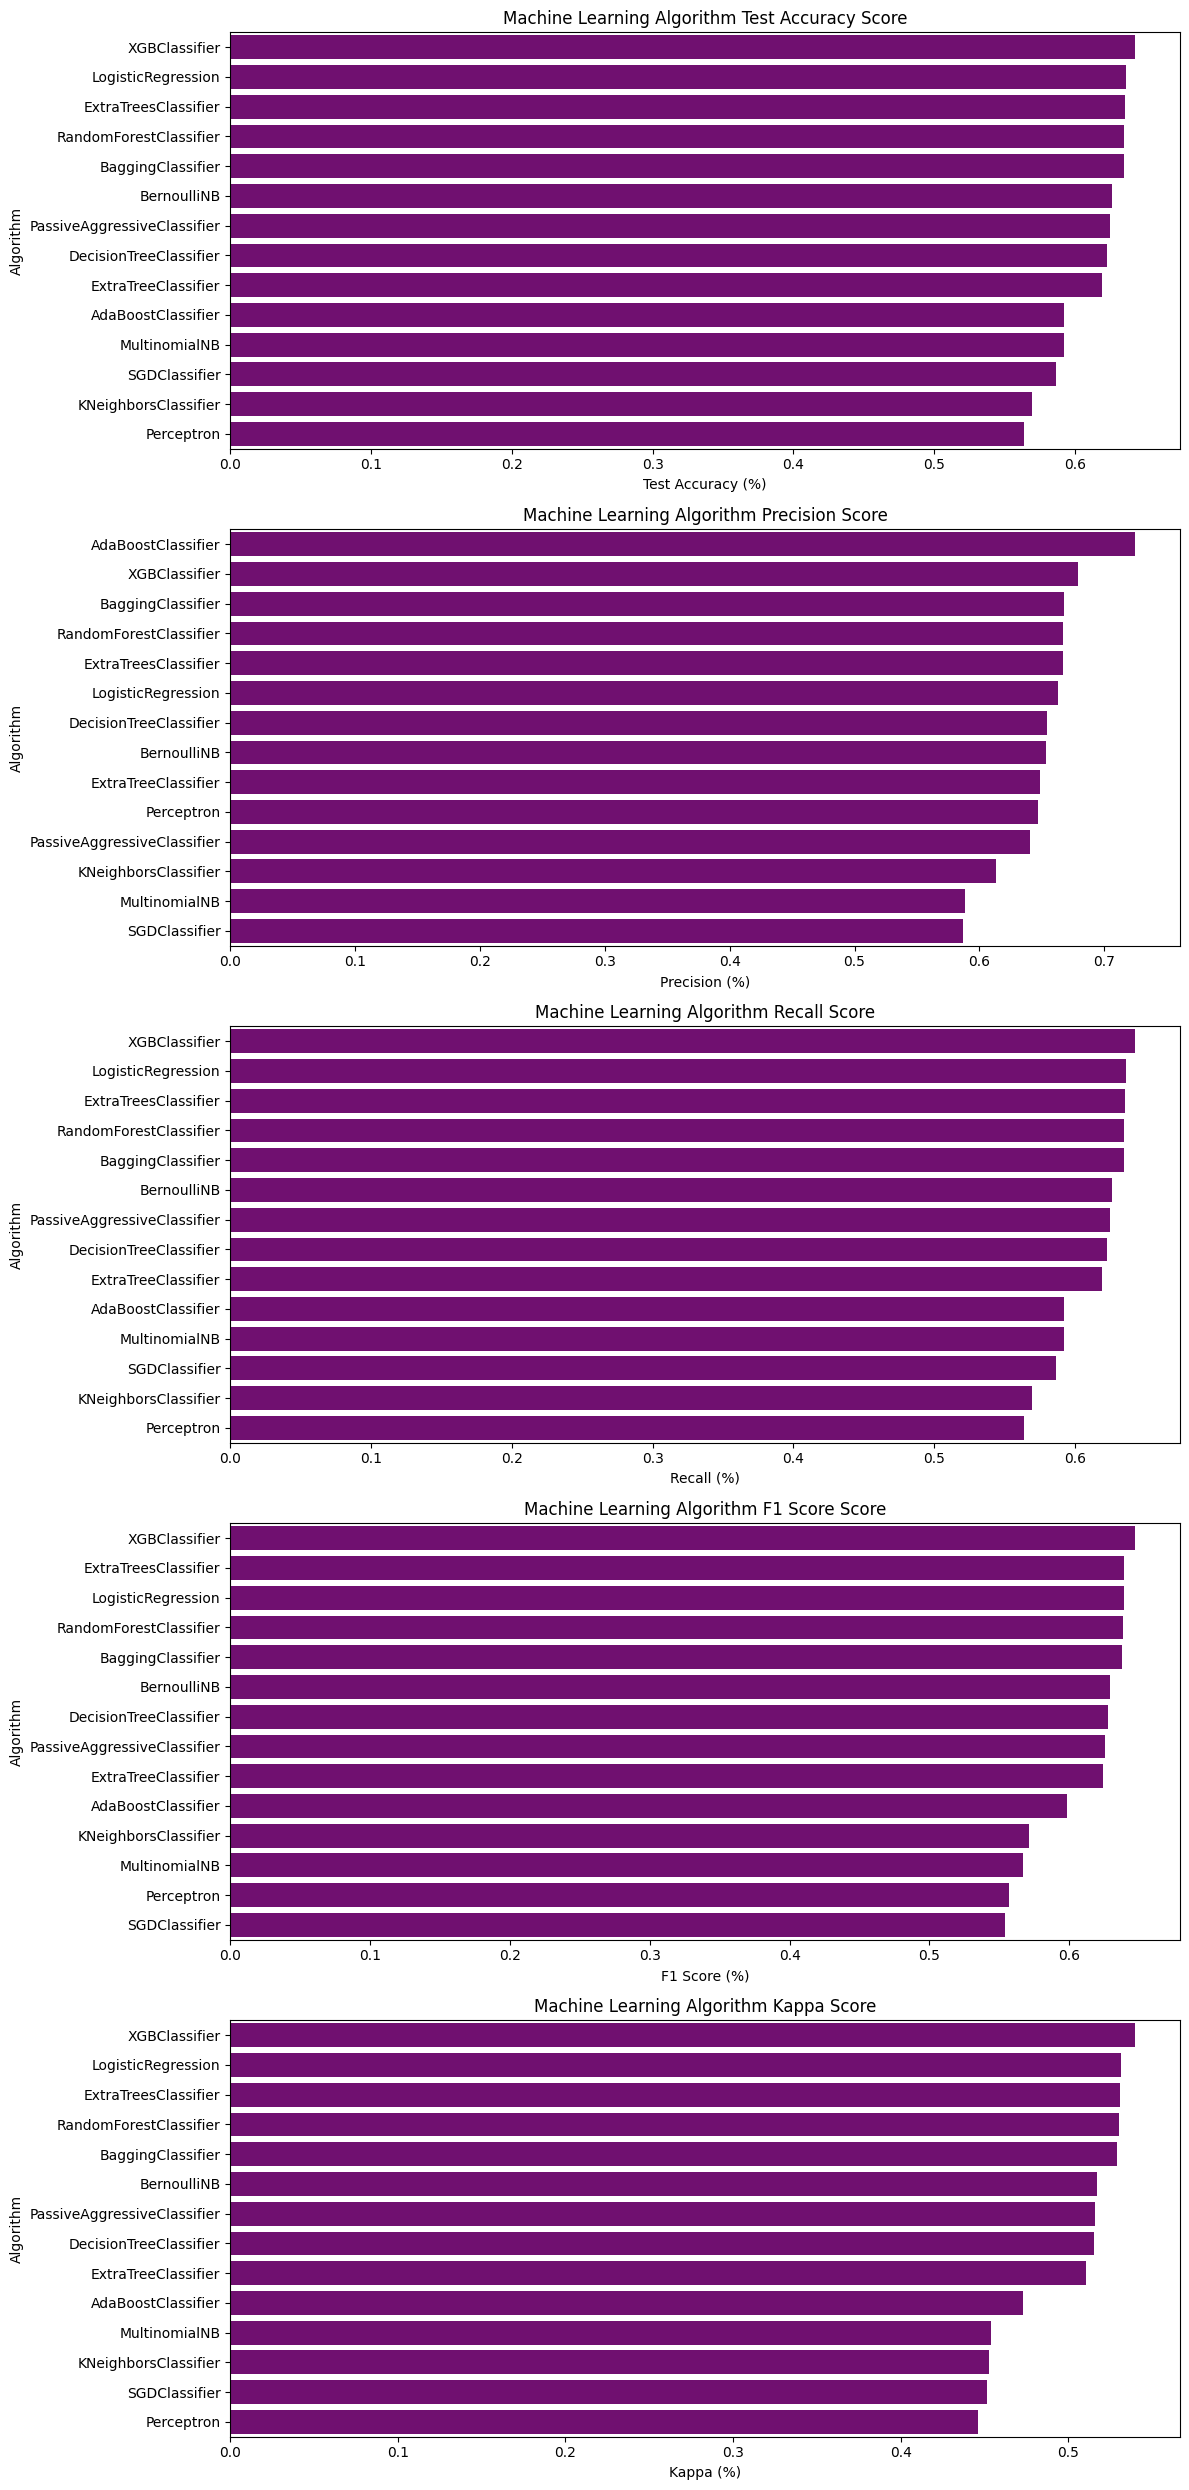

In [16]:
metrics_to_plot = ["test_accuracy", "precision", "recall", "f1_score", "kappa"]

# Set figure size based on the number of metrics
plt.figure(figsize=(12, 5 * len(metrics_to_plot)))

# Loop through each metric and create a subplot
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(len(metrics_to_plot), 1, i)  # Arrange plots vertically
    results_sorted = results_df.sort_values(by=metric, ascending=False)  # Sort by metric

    sns.barplot(x=metric, y="model", data=results_sorted, color="purple")

    plt.xlabel(f"{metric.replace('_', ' ').title()} (%)")  # Format label names
    plt.ylabel("Algorithm")
    plt.title(f"Machine Learning Algorithm {metric.replace('_', ' ').title()} Score")

plt.tight_layout()
plt.show()

###  Visualization of composite metric.


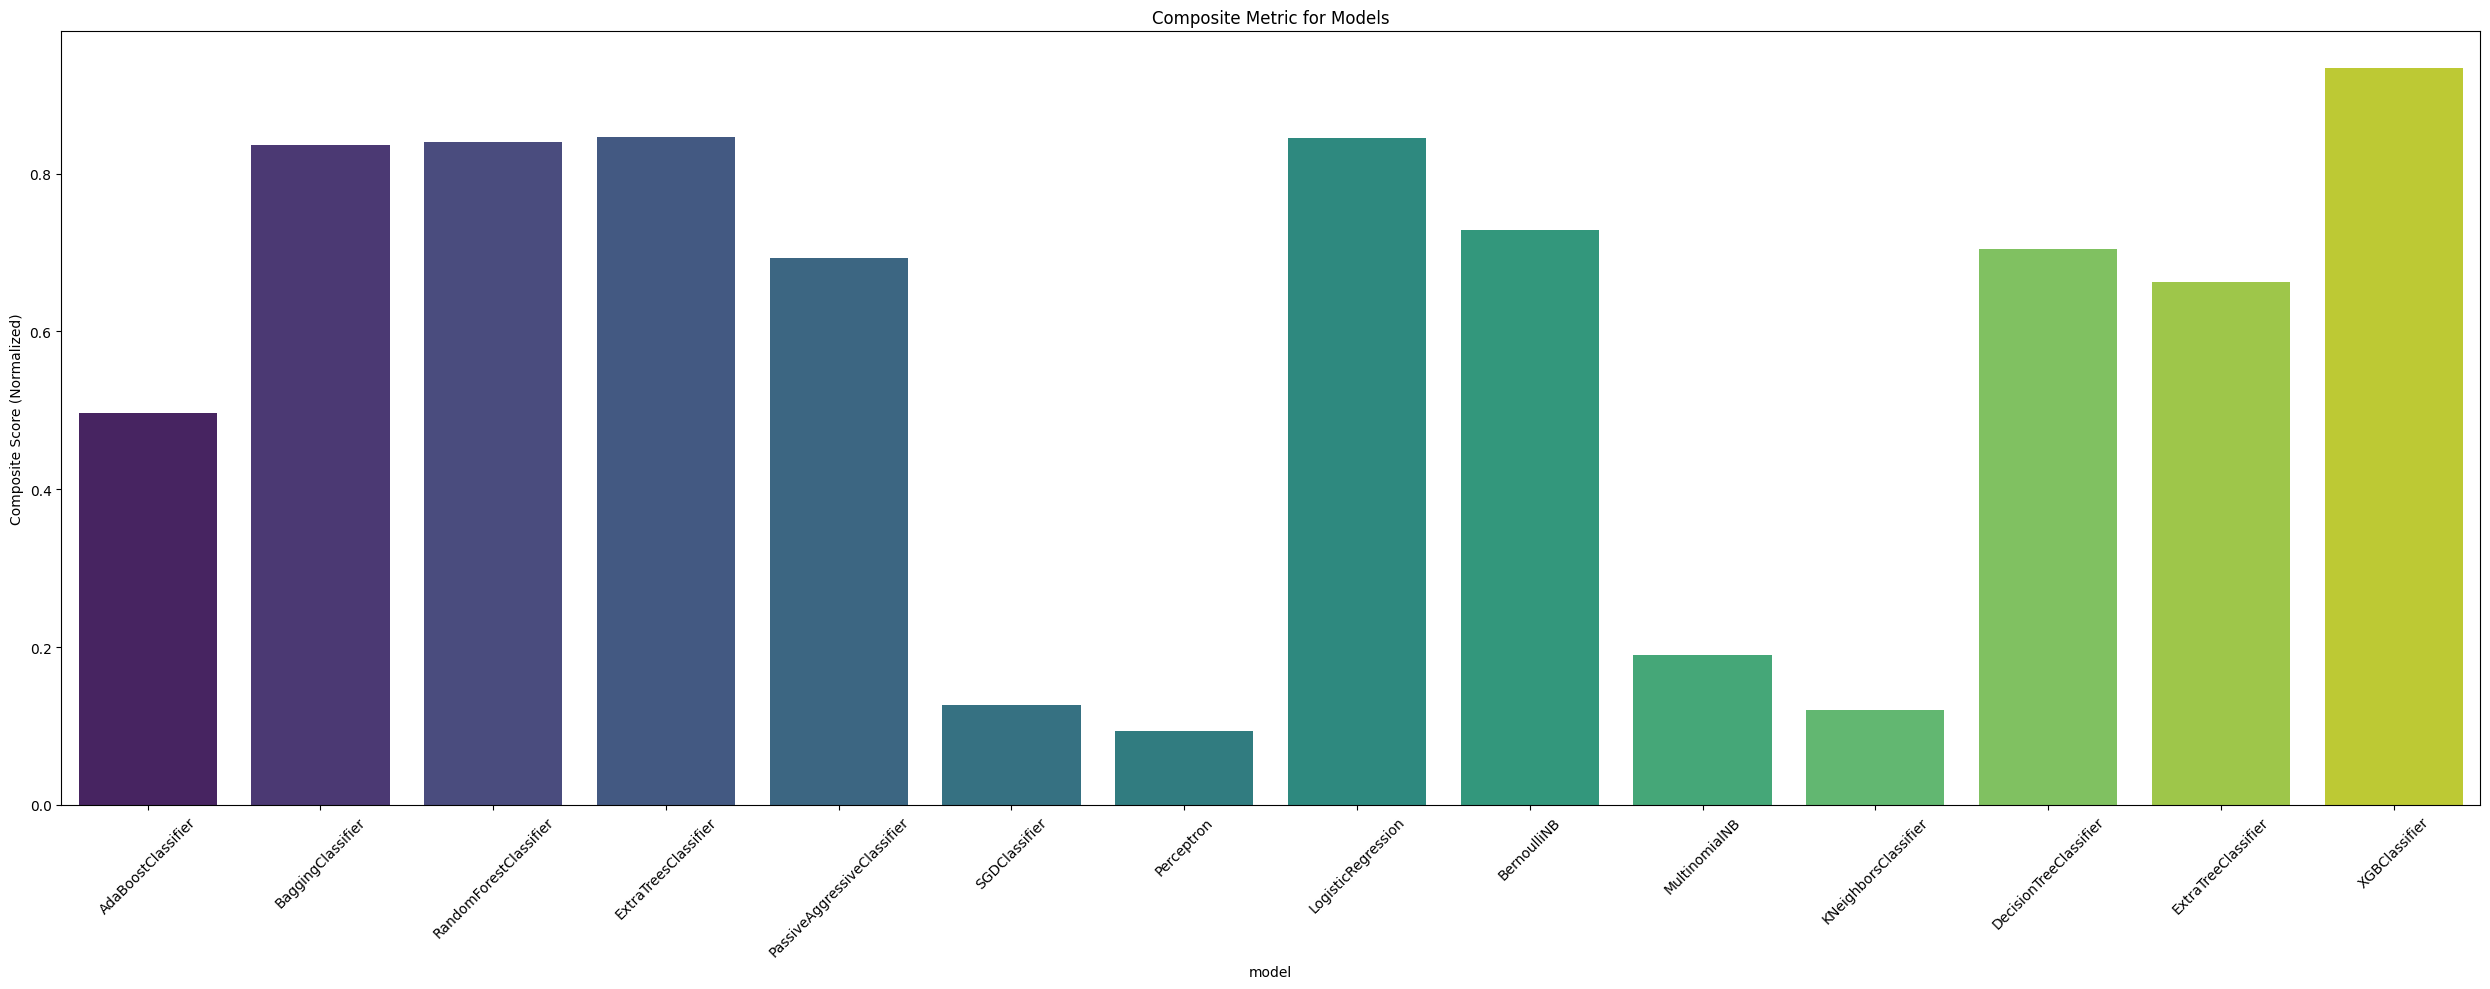

In [17]:
plt.figure(figsize=(25, 10))
sns.barplot(x='model', y='composite_metric', data=results_df, palette="viridis")
plt.title("Composite Metric for Models")
plt.xticks(rotation=45)
plt.ylabel("Composite Score (Normalized)")
plt.tight_layout()
plt.show()